In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import shap
import torch
from scipy.ndimage import gaussian_filter

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240224-103820_task_0/model_10000000.pt"
model = QNetwork(frame_stacks=1, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240224-103820_task_0/model_10000000.pt


In [4]:
env_steps = Concept.load_concept_data()
concept = concept_instances['random continuous']
concept.prepare_data(env_steps)
observations = concept.train_obs

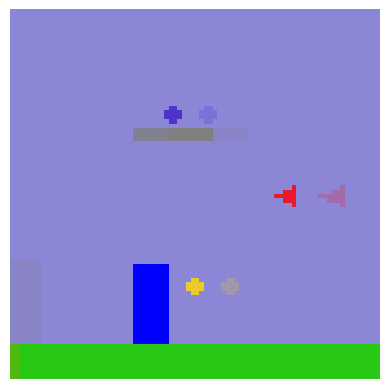

In [29]:
example_idx = 0
example_obs_np = observations[example_idx]
plt.imshow(example_obs_np)
plt.axis('off')
plt.show()

In [18]:
example_obs = torch.tensor([example_obs_np], dtype=torch.float32)
example_obs.requires_grad = True
q_values = model(example_obs)
action = q_values.argmax(dim=1).item()
chosen_q_value = q_values[0, action]

In [19]:
model.zero_grad()
chosen_q_value.backward()
gradients = example_obs.grad[0].numpy()
gradients = gradients.sum(axis=2) / np.abs(gradients).max() # Sum over channels

positive_gradients = np.maximum(0, gradients)
negative_gradients = np.maximum(0, -gradients)

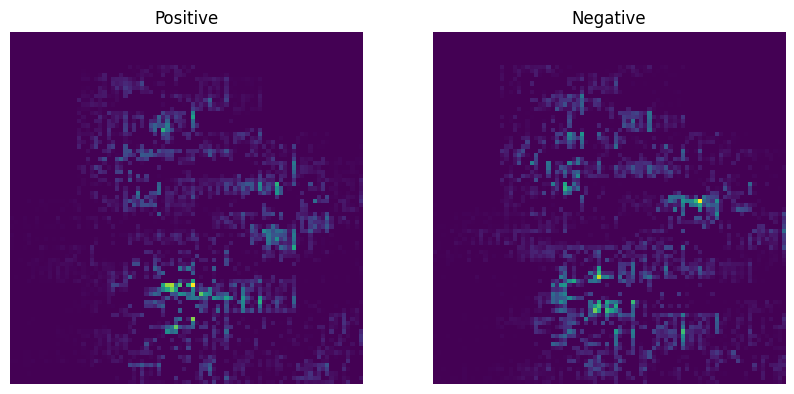

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot positive gradients
axs[0].imshow(positive_gradients)
axs[0].axis('off')
axs[0].set_title('Positive')

# Plot negative gradients
axs[1].imshow(negative_gradients)
axs[1].axis('off')
axs[1].set_title('Negative')

plt.show()

In [21]:
sigma = 2
positive_gradients_smooth = gaussian_filter(positive_gradients, sigma=sigma)
negative_gradients_smooth = gaussian_filter(negative_gradients, sigma=sigma)

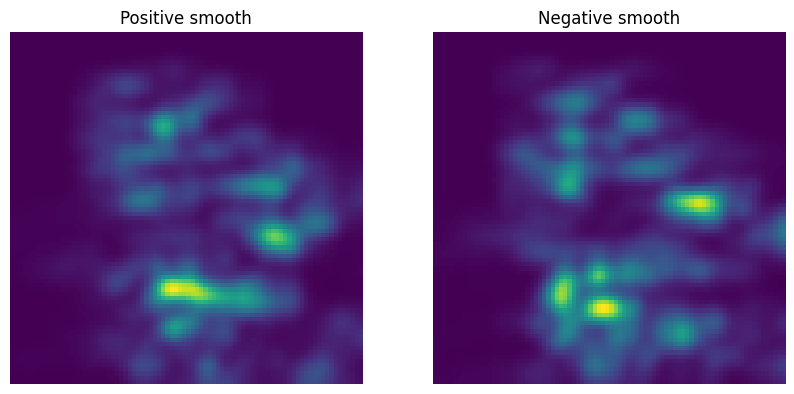

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot positive gradients
axs[0].imshow(positive_gradients_smooth)
axs[0].axis('off')
axs[0].set_title('Positive smooth')

# Plot negative gradients
axs[1].imshow(negative_gradients_smooth)
axs[1].axis('off')
axs[1].set_title('Negative smooth')

plt.show()

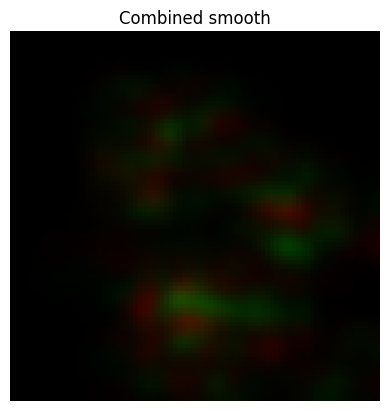

In [23]:
# Create a combined heatmap, where positive is green and negative is red
heatmap = np.zeros((84, 84, 3))
heatmap[:, :, 0] = negative_gradients_smooth
heatmap[:, :, 1] = positive_gradients_smooth

plt.imshow(heatmap)
plt.axis('off')
plt.title('Combined smooth')
plt.show()

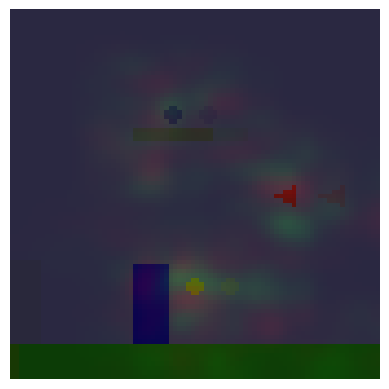

In [24]:
# Show the heatmap on top of the original image
plt.imshow(example_obs_np)
plt.imshow(heatmap, alpha=0.7)
plt.axis('off')
plt.show()

In [25]:
background_data = torch.tensor(observations, dtype=torch.float32)
class_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

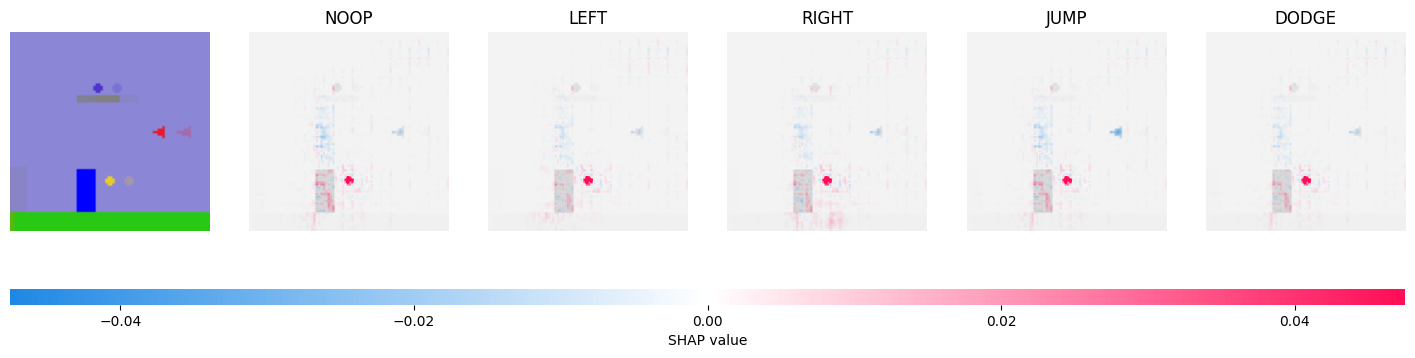

In [26]:
target_observation = torch.tensor([observations[example_idx]], dtype=torch.float32)

explainer = shap.GradientExplainer(model, background_data)

# Generate SHAP values for the target observation
shap_values = explainer.shap_values(target_observation)

# Visualize the SHAP values for the target observation
shap.image_plot(shap_values, target_observation.numpy().astype(int), class_names)

In [27]:
def predict(np_array):
    return model(torch.tensor(np_array, dtype=torch.float32))

masker_blur = shap.maskers.Image("blur(16,16)", observations[0].shape)
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

  0%|          | 0/9998 [00:00<?, ?it/s]

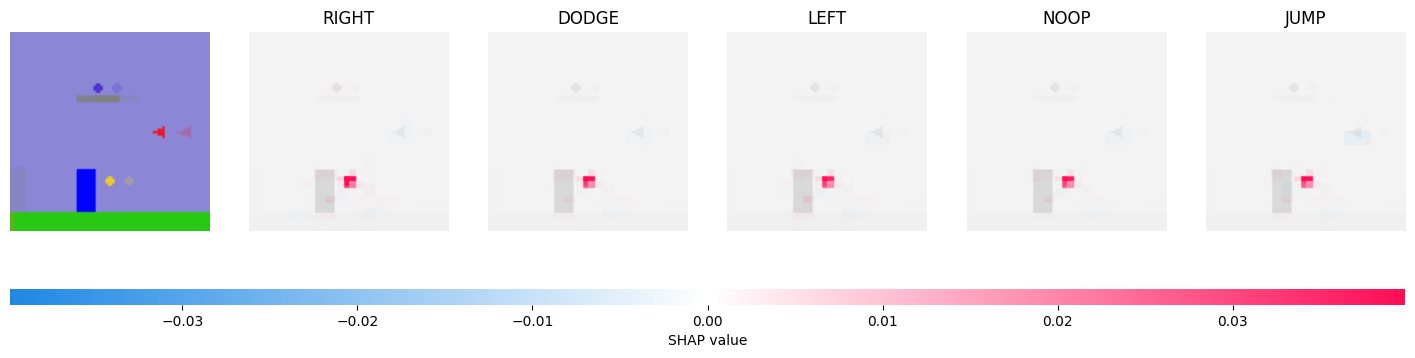

In [30]:
shap_values = explainer(
    observations[example_idx:example_idx+1],
    max_evals=10000,
    batch_size=8,
    outputs=shap.Explanation.argsort.flip[:5]
)

shap.image_plot(shap_values, shap_values.data)